In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import warnings# warning filter
import os

#ploting libraries
import matplotlib.pyplot as plt 
import seaborn as sns

#relevant ML libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#ML models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#default theme
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

#warning hadle
warnings.filterwarnings("ignore")

# The main objective for this dataset:

Using machine learning techniques to predict loan payments.

**target value:** Loan_Status

In [2]:
#list all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/loan-data/train.csv
/kaggle/input/loan-data/test.csv


In [3]:
#path for the training set
tr_path = "../input/loan-data/train.csv"
#path for the testing set
te_path = "../input/loan-data/test.csv"

# Preprocessing and Data Analysis

In [4]:
# read in csv file as a DataFrame
tr_df = pd.read_csv(tr_path)
# explore the first 5 rows
tr_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
# read in csv file as a DataFrame
te_df = pd.read_csv(te_path)
# explore the first 5 rows
te_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [6]:
#Size of each data set:
print(f"training set (row, col): {tr_df.shape}\n\ntesting set (row, col): {te_df.shape}")

training set (row, col): (614, 13)

testing set (row, col): (367, 12)


In [7]:
#Now the focus is shifted for the preprocessing of the training dataset
#column information
tr_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [8]:
#summary statistics
tr_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [9]:
#the Id column is not needed, let's drop it for both test and train datasets
tr_df.drop('Loan_ID',axis=1,inplace=True)
te_df.drop('Loan_ID',axis=1,inplace=True)
#checking the new shapes
print(f"training set (row, col): {tr_df.shape}\n\ntesting set (row, col): {te_df.shape}")

training set (row, col): (614, 12)

testing set (row, col): (367, 11)


In [10]:
#missing values in decsending order
tr_df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [11]:
#filling the missing data
print("Before filling missing values\n\n","#"*50,"\n")
null_cols = ['Credit_History', 'Self_Employed', 'LoanAmount','Dependents', 'Loan_Amount_Term', 'Gender', 'Married']


for col in null_cols:
    print(f"{col}:\n{tr_df[col].value_counts()}\n","-"*50)
    tr_df[col] = tr_df[col].fillna(
    tr_df[col].dropna().mode().values[0] )   

    
tr_df.isnull().sum().sort_values(ascending=False)
print("After filling missing values\n\n","#"*50,"\n")
for col in null_cols:
    print(f"\n{col}:\n{tr_df[col].value_counts()}\n","-"*50)

Before filling missing values

 ################################################## 

Credit_History:
1.0    475
0.0     89
Name: Credit_History, dtype: int64
 --------------------------------------------------
Self_Employed:
No     500
Yes     82
Name: Self_Employed, dtype: int64
 --------------------------------------------------
LoanAmount:
120.0    20
110.0    17
100.0    15
160.0    12
187.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: LoanAmount, Length: 203, dtype: int64
 --------------------------------------------------
Dependents:
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
 --------------------------------------------------
Loan_Amount_Term:
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64
 --------------------------------------------------
Gender:
Male      489
Female    112
Name: Gender, dtype

In [12]:
#Loan status distribution
#list of all the columns.columns
#Cols = tr_df.tolist()
#list of all the numeric columns
num = tr_df.select_dtypes('number').columns.to_list()
#list of all the categoric columns
cat = tr_df.select_dtypes('object').columns.to_list()

#numeric df
loan_num =  tr_df[num]
#categoric df
loan_cat = tr_df[cat]

Y    422
N    192
Name: Loan_Status, dtype: int64


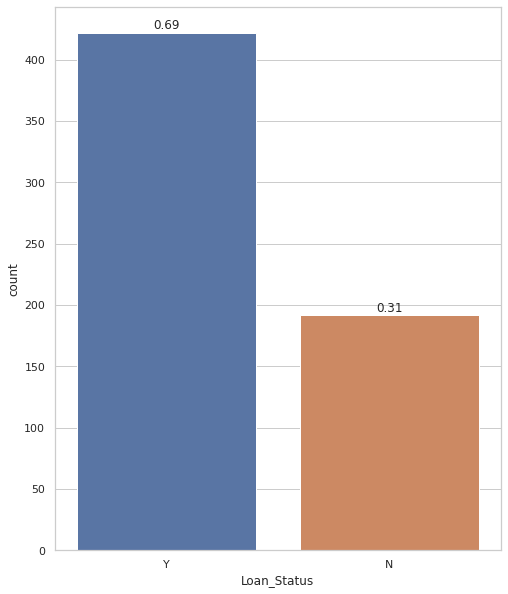

In [13]:
print(tr_df[cat[-1]].value_counts())
#tr_df[cat[-1]].hist(grid = False)

#print(i)
total = float(len(tr_df[cat[-1]]))
plt.figure(figsize=(8,10))
sns.set(style="whitegrid")
ax = sns.countplot(tr_df[cat[-1]])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.2f}'.format(height/total),ha="center") 
plt.show()

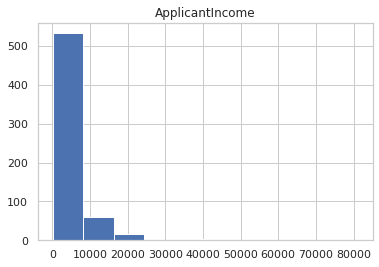

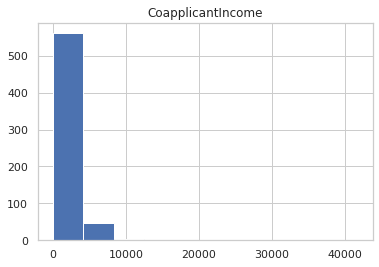

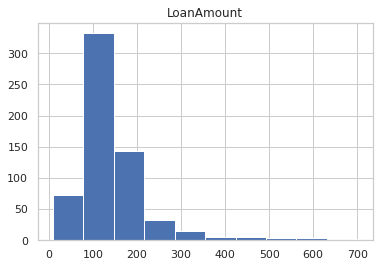

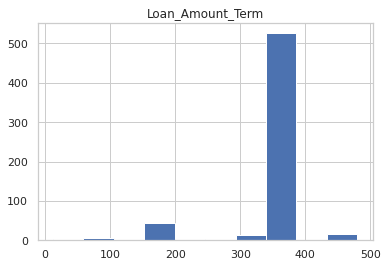

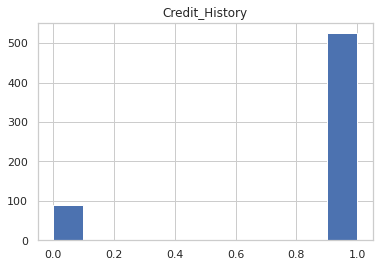

In [14]:
#Let's plot our data
#Numeric:
for i in loan_num:
    plt.hist(loan_num[i])
    plt.title(i)
    plt.show()

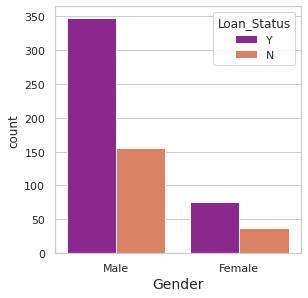

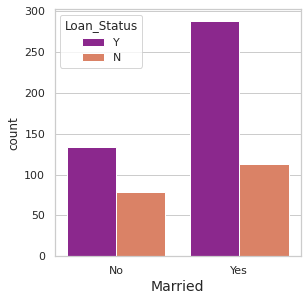

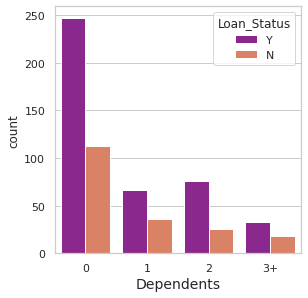

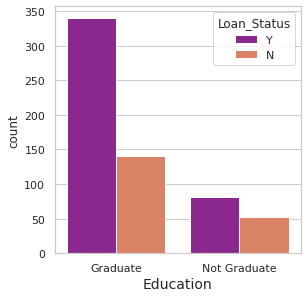

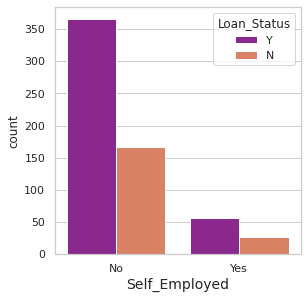

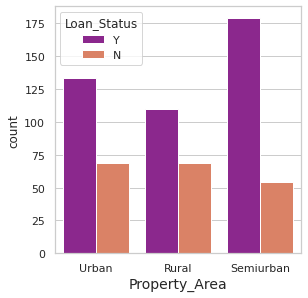

In [15]:
#Categorical (split by Loan status):
for i in cat[:-1]: 
    plt.figure(figsize=(15,10))
    plt.subplot(2,3,1)
    sns.countplot(x=i ,hue='Loan_Status', data=tr_df ,palette='plasma')
    plt.xlabel(i, fontsize=14)

In [16]:
#converting categorical values to numbers

to_numeric = {'Male': 1, 'Female': 2,
'Yes': 1, 'No': 2,
'Graduate': 1, 'Not Graduate': 2,
'Urban': 3, 'Semiurban': 2,'Rural': 1,
'Y': 1, 'N': 0,
'3+': 3}

# adding the new numeric values from the to_numeric variable to both datasets
tr_df = tr_df.applymap(lambda lable: to_numeric.get(lable) if lable in to_numeric else lable)
te_df = te_df.applymap(lambda lable: to_numeric.get(lable) if lable in to_numeric else lable)

# convertind the Dependents column
Dependents_ = pd.to_numeric(tr_df.Dependents)
Dependents__ = pd.to_numeric(te_df.Dependents)

# dropping the previous Dependents column
tr_df.drop(['Dependents'], axis = 1, inplace = True)
te_df.drop(['Dependents'], axis = 1, inplace = True)

# concatination of the new Dependents column with both datasets
tr_df = pd.concat([tr_df, Dependents_], axis = 1)
te_df = pd.concat([te_df, Dependents__], axis = 1)

# checking the our manipulated dataset for validation
print(f"training set (row, col): {tr_df.shape}\n\ntesting set (row, col): {te_df.shape}\n")
print(tr_df.info(), "\n\n", te_df.info())

training set (row, col): (614, 12)

testing set (row, col): (367, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Education          614 non-null    int64  
 3   Self_Employed      614 non-null    int64  
 4   ApplicantIncome    614 non-null    int64  
 5   CoapplicantIncome  614 non-null    float64
 6   LoanAmount         614 non-null    float64
 7   Loan_Amount_Term   614 non-null    float64
 8   Credit_History     614 non-null    float64
 9   Property_Area      614 non-null    int64  
 10  Loan_Status        614 non-null    int64  
 11  Dependents         614 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 57.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 11 column

<AxesSubplot:>

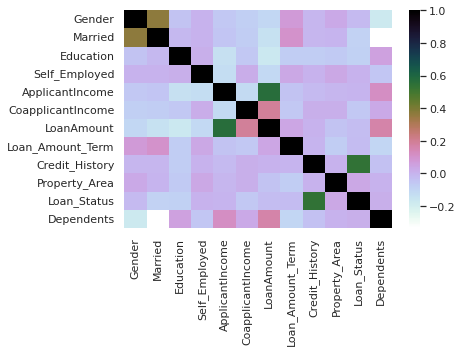

In [17]:
#plotting the correlation matrix
sns.heatmap(tr_df.corr() ,cmap='cubehelix_r')

In [18]:
#correlation table
corr = tr_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Dependents
Gender,1.00,0.36,-0.05,-0.00,-0.06,-0.08,-0.11,0.07,-0.01,0.03,-0.02,-0.17
Married,0.36,1.00,-0.01,0.00,-0.05,-0.08,-0.15,0.10,-0.01,-0.00,-0.09,-0.33
Education,-0.05,-0.01,1.00,0.01,-0.14,-0.06,-0.17,-0.07,-0.07,-0.07,-0.09,0.06
Self_Employed,-0.00,0.00,0.01,1.00,-0.13,0.02,-0.11,0.03,0.00,0.03,0.00,-0.06
ApplicantIncome,-0.06,-0.05,-0.14,-0.13,1.00,-0.12,0.56,-0.05,-0.02,-0.01,-0.00,0.12
CoapplicantIncome,-0.08,-0.08,-0.06,0.02,-0.12,1.00,0.19,-0.06,0.01,0.01,-0.06,0.03
LoanAmount,-0.11,-0.15,-0.17,-0.11,0.56,0.19,1.00,0.04,-0.00,-0.05,-0.03,0.16
Loan_Amount_Term,0.07,0.10,-0.07,0.03,-0.05,-0.06,0.04,1.00,-0.00,-0.08,-0.02,-0.10
Credit_History,-0.01,-0.01,-0.07,0.00,-0.02,0.01,-0.00,-0.00,1.00,0.00,0.54,-0.04
Property_Area,0.03,-0.00,-0.07,0.03,-0.01,0.01,-0.05,-0.08,0.00,1.00,0.03,-0.00


We can clearly see that Credit_History has the highest correlation with Loan_Status (a positive correlation of 0.54). Therefore our target value is highly dependant on this column.

# ****Machine learning models****

First of all we will divide our dataset into two variables X as the features we defined earlier and y as the Loan_Status the target value we want to predict.

In [19]:
y = tr_df['Loan_Status']
X = tr_df.drop('Loan_Status', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

**Models we will use:**

Decision Tree

Random Forest

XGBoost

Logistic Regression

**The Process of Modeling the Data:**

Importing the model

Fitting the model

Predicting Loan Status

Classification report by Loan Status

Overall accuracy

In [20]:
#Decision Tree
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

y_predict = DT.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
DT_SC = accuracy_score(y_predict,y_test)
print(f"{round(DT_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.45      0.53      0.49        51
           1       0.81      0.75      0.78       134

    accuracy                           0.69       185
   macro avg       0.63      0.64      0.63       185
weighted avg       0.71      0.69      0.70       185

69.19% Accurate


In [21]:
#Random Forest
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

y_predict = RF.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
RF_SC = accuracy_score(y_predict,y_test)
print(f"{round(RF_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.65      0.43      0.52        51
           1       0.81      0.91      0.86       134

    accuracy                           0.78       185
   macro avg       0.73      0.67      0.69       185
weighted avg       0.76      0.78      0.76       185

77.84% Accurate


In [22]:
#XGBoost
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

y_predict = XGB.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
XGB_SC = accuracy_score(y_predict,y_test)
print(f"{round(XGB_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.65      0.55      0.60        51
           1       0.84      0.89      0.86       134

    accuracy                           0.79       185
   macro avg       0.74      0.72      0.73       185
weighted avg       0.79      0.79      0.79       185

79.46% Accurate


In [23]:
#Logistic Regression
LR = LogisticRegression()
LR.fit(X_train, y_train)

y_predict = LR.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
LR_SC = accuracy_score(y_predict,y_test)
# print('accuracy is',accuracy_score(y_predict,y_test))
print(f"{round(LR_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.92      0.43      0.59        51
           1       0.82      0.99      0.89       134

    accuracy                           0.83       185
   macro avg       0.87      0.71      0.74       185
weighted avg       0.85      0.83      0.81       185

83.24% Accurate


In [24]:
Logistic_Regression=pd.DataFrame({'y_test':y_test,'prediction':y_predict})
Logistic_Regression.to_csv("Logistic Regression.csv") 
Logistic_Regression.to_pickle('Logistic Regression.pkl')

# Conclusion

* Credit_History is a very important variable because of its high correlation with Loan_Status therefor showind high Dependancy for the latter.
* The Logistic Regression algorithm is the most accurate: approximately 83%.

In [25]:
score = [DT_SC,RF_SC,XGB_SC,LR_SC]
Models = pd.DataFrame({
    'n_neighbors': ["Decision Tree","Random Forest","XGBoost", "Logistic Regression"],
    'Score': score})
Models.sort_values(by='Score', ascending=False)

,n_neighbors,Score
3,Logistic Regression,0.832432
2,XGBoost,0.794595
1,Random Forest,0.778378
0,Decision Tree,0.691892
